# **Intrusion Dection**

## Indice

1. [Introduzione](#introduzione)
2. [Analisi dei Dati & Data Preprocessing](#analisi-dei-dati--data-preprocessing)
3. [Definizione delle Metriche Utilizzate](#definizione-delle-metriche-utilizzate)
4. [Implementazione dei Modelli](#implementazione-dei-modelli)

## Introduzione

Lo scopo di questo progetto è quello di addestrare e valutare più modelli in grado di classificare i flussi e riconoscere diversi tipi di attacchi, ovvero modelli utilizzati per task di classificazione multiclasse.

L'insieme di dati utilizzato è il dataset NSL-KDD (KDDTrainClean.csv) che rappresenta un benchmark per sistemi di *Intrusion Detection*. Il dataset contiene informazioni sui flussi di rete verso una infrastruttura IT. Ogni flusso è etichettato come "normale" o associato ad una tipologia di attacco dove la colonna *label* rappresenta l'etichetta. 

In [4]:
# Import delle lebrerie

import os
import logging
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import shutil
import keras_tuner as kt
import tensorflow as tf
from keras_tuner import RandomSearch
from tensorflow import keras
from keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.metrics import geometric_mean_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score, matthews_corrcoef, precision_score, recall_score, f1_score

# Ignora i warning
warnings.filterwarnings("ignore")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Questo rimuove i log informativi e warnings di TensorFlow
tf.get_logger().setLevel(logging.ERROR)

os.environ['PYTHONWARNINGS'] = 'ignore'

logging.getLogger('tensorflow').setLevel(logging.ERROR)

# pulisci directory di keras tuner
shutil.rmtree('tuning/', ignore_errors=True)

In [5]:
# Carico il dataset
dataset_path = "./KDDTrainClean.csv"
dataset = pd.read_csv(dataset_path)

# Per vericare che il daset venga caricato correttamente, conto le righe del dataset stesso.
print(len(dataset))

# Ottengo informazioni sul dataset in utilizzo
print(dataset.info())

125973
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64

## Analisi dei Dati & Data Preprocessing

Per prima cosa si è deciso di fare un'analisi preliminare dei dati all'interno del dataset, analizzando il numero di classi e la loro distribuzione.

In [6]:
class_counts = dataset['label'].value_counts()

# Visualizziamo la distribuzione delle classi
print(class_counts)

label
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64


Si utilizza un grafico a barre per rappresentare la distribuzione.

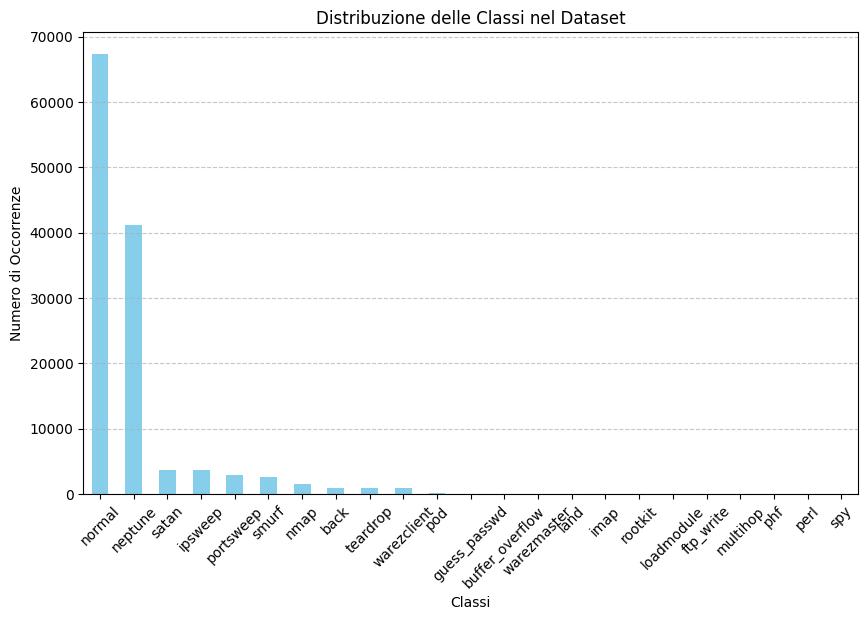

In [7]:
class_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Distribuzione delle Classi nel Dataset')
plt.xlabel('Classi')
plt.ylabel('Numero di Occorrenze')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Si nota come il dataset sia sbilanciato per certe tipologie di classi e questo potrebbe portare a comportamenti di overfitting per quelle particolari classi più comuni che comporterebbe ai modelli utilizzati per il task di non essere in grado di generalizzare meglio e di non essere in grado di riconoscere i casi più rari che non sono così comuni all'interno del dataset.

Infatti le classi '*guess_passwd*', '*buffer_overflow*', '*warezmaster*', '*land*', '*imap*', '*rootkit*', '*loadmodule*', '*ftp_write*', '*multihop*', '*phf*', '*perl*' e '*spy*' hanno ripettivamente meno di 100 tuple all'interno del dataset, alcune anche meno di 10. I modelli potrebbero non essere in grado di riuscire a classificare correttamente le istanze.

Per cercare di risolvere il problema si potrebbe pensare di introdurre dei dati sintentici, quindi utilizzare la tecnica del **dataset agumentation**. In questo modo si potrebbe risolvere il problema del ribilanciamento delle classi in modo tale che le classi meno comuni siano in un numero sufficiente così da consentire ai modelli di apprendere in modo efficiente, aggiungendo dei dati sintetici porterebbe migliorare la capacità dei modelli di generalizzare riducendo l'overfitting sulle classi dominanti e si ridurrebbe lo sbilanciamento così da ottenere delle prestazioni migliori.

Ci sono però delle considerazioni da fare sull'aggiunta dei dati sintetici:
- i dati sintentici che vengono aggiunti devono essere realistici e coerenti con il dominio del problema, nel caso in non lo fossero potrebbero influire negativamente sulle prestazioni dei modelli;
- si potrebbe cadere in casi di overfitting perché creando dei dati sintetici per le classi rare si potrebbe indurre i modelli a memorizzare i pattern artificiali piuttosto che apprendere le caratteristiche generali;
- se i dati sintetici che vengono generati venissero utilizati sia in fasi di training che in fasi di testing si potrebbe fornire un'immagine ottimistica delle prestazioni dei modelli che vengono costruiti.

Per cercare di utilizzare l'idea di utilizzare i dati sintentici per otteneri i benefici di generalizzazione ma cercando di limitarne l'utilizzo si utilizza un approccio mirato. Si utilizza **Smote (Synthetic Minority Over-sampling Technique)** in modo tale da generare degli esempi sintetici interpolando dati delle classi reali limitando l'utilizzo solo alle classi rare, ovvero solo alle classi precendentemente citate. 

In [8]:
# Conto le occorrenze per singole classi
class_counts = dataset['label'].value_counts()

# Definisco un valore di soglia in modo tale da poter individaure le classi più rare 
threshold = 100 

# Trovo le classi sotto la soglia
underrepresented_classes = class_counts[class_counts < threshold].index
print("Classi sotto la soglia:", underrepresented_classes)

Classi sotto la soglia: Index(['guess_passwd', 'buffer_overflow', 'warezmaster', 'land', 'imap',
       'rootkit', 'loadmodule', 'ftp_write', 'multihop', 'phf', 'perl', 'spy'],
      dtype='object', name='label')


Prima di applicare **SMOTE** bisogna trasformare quelle caratteristiche che non sono dati numerici. 

In [30]:
# Divido il dataset in caratteristiche e target
X = dataset.drop(columns=['label'])
y = dataset['label']

number_of_classes = dataset['label'].nunique()

# Identifico le colonne categoriche
categorical_columns = X.select_dtypes(include=['object']).columns
numeric_columns = X.select_dtypes(exclude=['object']).columns

# Configuro l'encoder per le caratteristiche categoriche
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('num', 'passthrough', numeric_columns)
    ]
)

# Trasformo le colonne
X_encoded = preprocessor.fit_transform(X)

X_encoded = pd.DataFrame(
    X_encoded.toarray() if hasattr(X_encoded, 'toarray') else X_encoded,
    columns=preprocessor.get_feature_names_out()
)


IndexError: tuple index out of range

In [12]:
# Suddivido in training set e test set
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Creo un dizionario con il numero di istanze desiderate per ogni classe rara all'interno del dataset
desired_instances = {class_label: 100 for class_label in underrepresented_classes} 

Prima di applicare correttamente **SMOTE**, si applica una tecnica di oversamplig più semplice duplicando i campioni in minoranza. A questo proposito viene utilizzato *RandomOverSampler* che aiuta a stabilizzare le classi minoritarie aumentandone il numero di esempi. Questo viene fatto perché altrimenti non si riuscirebbe a generare dei dati sintentici per classi che hanno meno istanze. Una volta applicata la duplicazione, si generano i dati sintetici

In [13]:
# Eseguo un oversampling casuale prima di SMOTE
ros = RandomOverSampler(sampling_strategy=desired_instances, random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

# Poi applica SMOTE
smote = SMOTE(sampling_strategy=desired_instances, k_neighbors=1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_ros, y_ros)

In [14]:
# Conta le occorrenze per classe
balanced_counts = y_resampled.value_counts()
print("Distribuzione bilanciata delle classi:")
print(balanced_counts)

Distribuzione bilanciata delle classi:
label
normal             47260
neptune            28792
satan               2543
ipsweep             2483
portsweep           2058
smurf               1852
nmap                1032
back                 680
teardrop             630
warezclient          597
pod                  135
imap                 100
guess_passwd         100
land                 100
loadmodule           100
ftp_write            100
buffer_overflow      100
perl                 100
multihop             100
warezmaster          100
rootkit              100
phf                  100
spy                  100
Name: count, dtype: int64


Come ultima cosa, si divide il training set in training set e validation set dopo aver applicato **SMOTE**.

In [15]:
# Divido il training set in training set e validation set
X_training, X_validation, y_training, y_validation = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

print("Taglia del Training Set:     ", len(X_training))
print("Taglia del Validation Set:   ", len(X_validation))
print("Taglia del Testing Set:      ", len(X_test))

Taglia del Training Set:      62483
Taglia del Validation Set:    26779
Taglia del Testing Set:       37792


## Definizione delle Metriche utilizzate

Le metriche utilizzate per la valutazione delle prestazioni dei modelli utilizzati sono:
- **Accuracy**;
- **Media Geometrica**: valuta l'equilibrio tra le prestazioni sulle diverse classi, viene utilizzata la seguente formula 
$\\ G_{Mean}=\sqrt{Sensitivity×Specificity}$;
- **Precision**;
- **Recall**;
- **F1-Score**;
- **Confusion Matrix**;
- **Cohen's Kappa**: valuta le predizioni del modello e quelle reali, tenendo condo anche del caso in cui il risultato sia dovuto al caso, viene utilizzata la seguente formula: 
$\\ Kappa = \frac{p_o - p_c}{1 - p_c} \\$
dove con $p_o$ si indica l'accuratezza osservata mentre con $p_c$ si indica l'accuratezza attesa casuale;
- **Matthews Correlation Coefficient (MCC)**: fornisce una valutazione globale delle prestazioni considerando tutte le voci della confusion matrix, si utilizza la seguente formula 
$\\ MCC = \frac{TP \cdot TN - FP \cdot FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}$; 
- **Heatmap della Confusion Matrix**: in questo modo è possibile rappresentare visivamente le prestazioni del modello evidenziando le classi più problematiche.

In [16]:
# Definizione di una funzione per valutare le metriche di valutazione dei modelli utilizzati per il task di interesse
def evaluate_model(y_true, y_pred):
    metrics = {}

    # Accuracy
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)

    # Media Geometrica
    metrics['Geometric Mean'] = geometric_mean_score(y_true, y_pred, average='macro')

    # Precision
    metrics['Precision'] = precision_score(y_true, y_pred, average='macro')

    # Recall
    metrics['Recall'] = recall_score(y_true, y_pred, average='macro')

    # F1-Score
    metrics['F1-Score'] = f1_score(y_true, y_pred, average='macro')

    # Confusion Matrix
    metrics['Confusion Matrix'] = confusion_matrix(y_true, y_pred)

    # Cohen's Kappa
    metrics['Cohen\'s Kappa'] = cohen_kappa_score(y_true, y_pred)

    # Matthews Correlation Coefficient (MCC)
    metrics['MCC'] = matthews_corrcoef(y_true, y_pred)

    return metrics

def show_confusion_matrix_heatmap(name, y_true, y_pred): 
    
    # Heatmap della Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true), ax=ax)
    ax.set_title('Confusion Matrix' + name)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    plt.show()

## Implementazione dei Modelli

A questo punto si è deciso di implementare i modelli, addestrarli e valutare le loro prestazioni.
Per poter confrontare i valori delle metriche si utilizza un dizionario per mantenere le prestazioni dei vari modelli utilizzati.

In [17]:
models_metrics = {}

### Random Forest

Un primo modello che si è deciso di utilizzare è il Random Forest; per il tuning degli iperparametri viene utilizzato RandomizedSearchCV.

In [18]:
# Inizializzazione del modello Random Forest
rf_model = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],                              # Numero di alberi nella finestra
    'max_depth': [10, 15, 20, 25, 30, 35, None],                                                    # Profondità massima degli alberi
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],      # Numero minimo di campioni per dividere un nodo
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],                                            # Numero minimo di campioni che un nodo foglia deve contenere
    'max_features': ['auto', 'sqrt', 'log2'],                                                       # Numero di caratteristiche da considerare per la divisione del nodo
    'bootstrap': [True, False],                                                                     # Se usare o meno il bootstrap
    'criterion': ['gini', 'entropy'],                                                               # Criterio di divisione
    'class_weight': ['balanced', None]                                                              # Pesi delle classi
}

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_resampled, y_resampled)
best_params = random_search.best_params_
print("Best hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'n_estimators': 50, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25, 'criterion': 'gini', 'class_weight': None, 'bootstrap': False}


In [19]:
#  Addestramento del modello con tutti i dati di addestramento, training e validation
final_random_forest_model = RandomForestClassifier(**best_params, random_state=42)
final_random_forest_model.fit(X_resampled, y_resampled)

y_pred_rf = final_random_forest_model.predict(X_test)

In [20]:
# Valuto le prestazioni del modello sul testing set

metrics_rf = evaluate_model(y_test, y_pred_rf)
models_metrics['Random Forest'] = metrics_rf

Una volta valutato il modello si mostrano i risultati ottenuti.

In [21]:
print("Accuracy Random Forest:              " + str(models_metrics['Random Forest']['Accuracy']))
print("Geometric Mean Random Forest:        " + str(models_metrics['Random Forest']['Geometric Mean']))
print("Precision Random Forest:             " + str(models_metrics['Random Forest']['Precision']))
print("Recall Random Forest:                " + str(models_metrics['Random Forest']['Recall']))
print("F1-Score Random Forest:              " + str(models_metrics['Random Forest']['F1-Score']))
print("Cohen's Kappa Random Forest:         " + str(models_metrics['Random Forest']['Cohen\'s Kappa']))
print("MCC Random Forest:                   " + str(models_metrics['Random Forest']['MCC']))


Accuracy Random Forest:              0.9980154530059272
Geometric Mean Random Forest:        0.8751242152427773
Precision Random Forest:             0.8107901319101624
Recall Random Forest:                0.7659598662139893
F1-Score Random Forest:              0.7745589594618569
Cohen's Kappa Random Forest:         0.996725023620669
MCC Random Forest:                   0.9967269316047211


E mostro il grafico della Confusion Matrix.

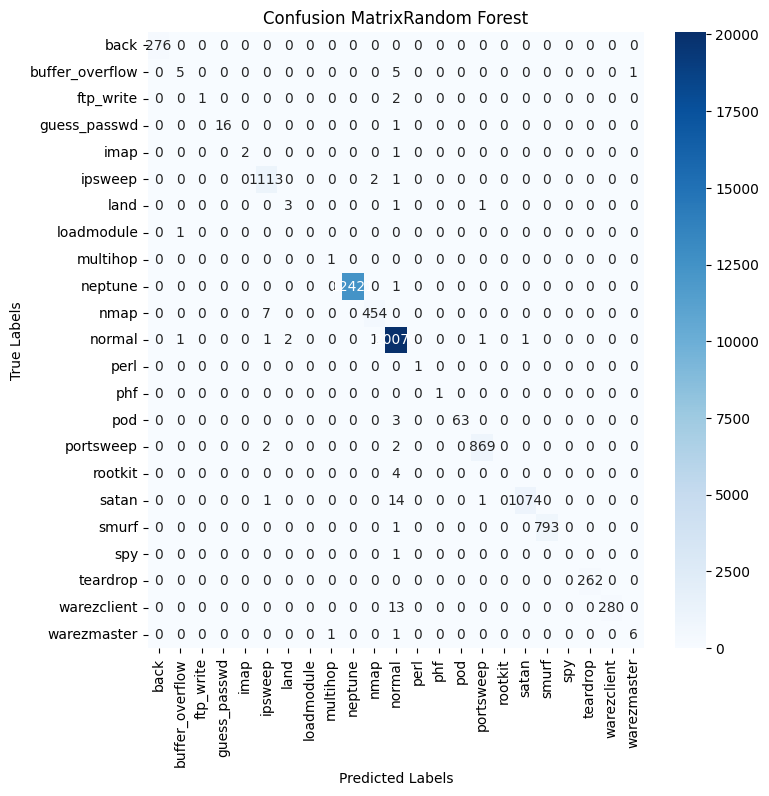

In [22]:
show_confusion_matrix_heatmap('Random Forest', y_test, y_pred_rf) 


### K-Nearest Neighbors (KNN)

Come secondo modello si è deciso di utilizzare KNN.<br>
Similmente al primo modello, si è utilizzato RandomizedSearchCV per ottenere i migliori iperparametri.

In [23]:
model_name = "KNN"

param_dist = {
    'n_neighbors': np.arange(1, 31),                                                # Numero di vicini da usare
    'weights': ['uniform', 'distance'],                                             # Funzione di peso usata per la previsione
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],                 # Metrica di distanza
    'p': [1, 2, 3],                                                                 # Parametro di potenza per la metrica Minkowski
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],                         # Algoritmo usato per trovare i vicini
}

knn_model = KNeighborsClassifier()

# Configurazione di RandomizedSearchCV con cross-validation a 5 fold
random_search = RandomizedSearchCV(
    estimator=knn_model,
    param_distributions=param_dist,
    n_iter=30,                                                                      # Numero di configurazioni di parametri campionate
    cv=5,                                                                           # Cross-validation a 5 fold
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)


random_search.fit(X_resampled, y_resampled)
best_params = random_search.best_params_
print("Best hyperparameters:", random_search.best_params_)

Best hyperparameters: {'weights': 'uniform', 'p': 1, 'n_neighbors': np.int64(1), 'metric': 'minkowski', 'algorithm': 'kd_tree'}


In [24]:
#  Addestramento del modello con tutti i dati di addestramento, training e validation
final_knn_model = KNeighborsClassifier(**best_params)
final_knn_model.fit(X_resampled, y_resampled)

y_pred_rf = final_knn_model.predict(X_test)

In [25]:
# Valuto le prestazioni del modello sul testing set

metrics_knn = evaluate_model(y_test, y_pred_rf)
models_metrics['KNN'] = metrics_knn

Una volta valutato il modello si mostrano i risultati ottenuti.

In [26]:
print("Accuracy KNN:              " + str(models_metrics['KNN']['Accuracy']))
print("Geometric Mean KNN:        " + str(models_metrics['KNN']['Geometric Mean']))
print("Precision KNN:             " + str(models_metrics['KNN']['Precision']))
print("Recall KNN:                " + str(models_metrics['KNN']['Recall']))
print("F1-Score KNN:              " + str(models_metrics['KNN']['F1-Score']))
print("Cohen's Kappa KNN:         " + str(models_metrics['KNN']['Cohen\'s Kappa']))
print("MCC KNN:                   " + str(models_metrics['KNN']['MCC']))


Accuracy KNN:              0.9907387806943269
Geometric Mean KNN:        0.8023601540946885
Precision KNN:             0.682697064473559
Recall KNN:                0.644090232536531
F1-Score KNN:              0.6600835030319898
Cohen's Kappa KNN:         0.9847357282067805
MCC KNN:                   0.984736702430962


E mostro il grafico della Confusion Matrix.

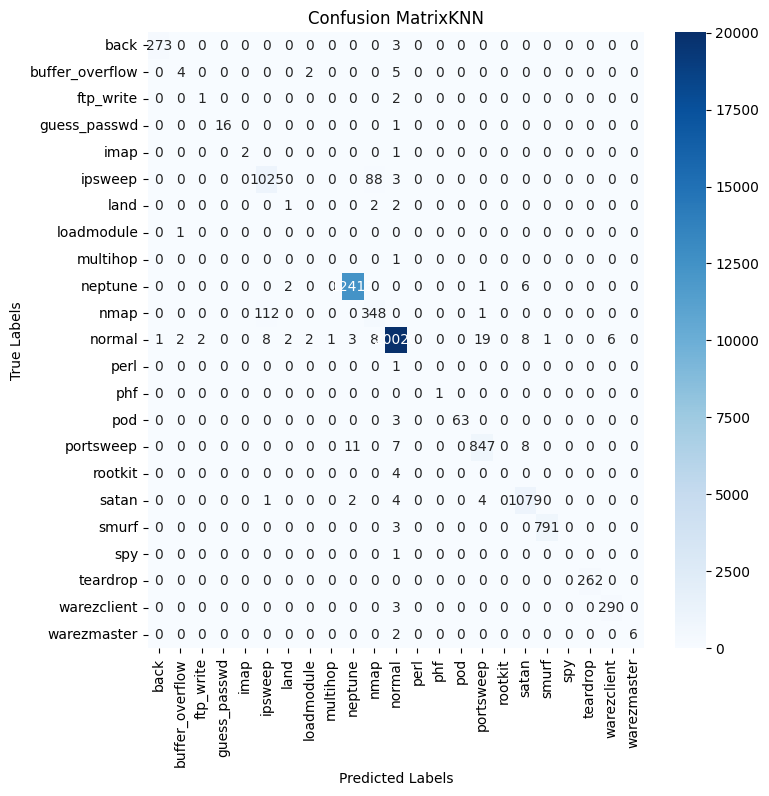

In [27]:
show_confusion_matrix_heatmap('KNN', y_test, y_pred_rf) 


### Deep Neural Network

Un altro modello che si è deciso di utilizzare è una rete naurale, ovvero un MPL. Per ottimizzare gli iperparametri viene utilizzato *Keras Tuner*. 

In [29]:
# Funzione utilizzata per costruire il modello con Keras Tuner
def build_model(hp):
    model = keras.Sequential()

    # Livello di Input
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=128, step=32), activation='relu', input_shape=(X_training.shape[1],)))

    # Possibilità di aggiungere uno o più livelli nascosti
    for i in range(hp.Int('num_hidden_layers', 1, 10)):  
        model.add(Dense(units=hp.Int(f'units_hidden_{i}', min_value=32, max_value=128, step=32), activation='relu'))
    
    # Aggiungi il layer di output
    model.add(Dense(number_of_classes, activation='softmax'))  

    # Ottimizzazione
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )

    return model

# Imposto EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Configuro il tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',  
    max_epochs=300,
    hyperband_iterations=50,
    directory='my_dir',
    project_name='nsl_kdd_nn'
)

# Faccio la ricerca degli iperparametri considerando il training set e il validation set
tuner.search(
    X_training,
    y_training,
    epochs=300,  
    validation_data=(X_validation, y_validation), 
    callbacks=[early_stopping]
)


Trial 2 Complete [00h 00m 00s]

Best val_accuracy So Far: None
Total elapsed time: 00h 00m 01s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
32                |64                |units_input
8                 |4                 |num_hidden_layers
96                |64                |units_hidden_0
0.00021192        |0.0017349         |learning_rate
128               |32                |units_hidden_1
96                |32                |units_hidden_2
32                |32                |units_hidden_3
128               |None              |units_hidden_4
96                |None              |units_hidden_5
32                |None              |units_hidden_6
64                |None              |units_hidden_7
128               |None              |units_hidden_8
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
5                 |5                 |tuner/bracket
0                 |0         

Traceback (most recent call last):
  File "/home/alessandro/miniconda3/envs/INTRUSION_DETECTION/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/alessandro/miniconda3/envs/INTRUSION_DETECTION/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/alessandro/miniconda3/envs/INTRUSION_DETECTION/lib/python3.10/site-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/alessandro/miniconda3/envs/INTRUSION_DETECTION/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/home/alessandro/miniconda3/envs/INTRUSION_DETECTION/lib/python3.10/s

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/home/alessandro/miniconda3/envs/INTRUSION_DETECTION/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/alessandro/miniconda3/envs/INTRUSION_DETECTION/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/alessandro/miniconda3/envs/INTRUSION_DETECTION/lib/python3.10/site-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/alessandro/miniconda3/envs/INTRUSION_DETECTION/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/home/alessandro/miniconda3/envs/INTRUSION_DETECTION/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/home/alessandro/miniconda3/envs/INTRUSION_DETECTION/lib/python3.10/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/home/alessandro/miniconda3/envs/INTRUSION_DETECTION/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/alessandro/miniconda3/envs/INTRUSION_DETECTION/lib/python3.10/site-packages/optree/ops.py", line 752, in tree_map
    return treespec.unflatten(map(func, *flat_args))
ValueError: Invalid dtype: object
